<a href="https://colab.research.google.com/github/MarcoRalli/SafeCarSystem/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
!pip install tensorflow==2.9.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 98.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.1.21
    Uninstalling flatbuffers-23.1.21:
      Successfully uninstalled flatbuffers-23.1.21
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully u

In [ ]:
from tensorflow import keras
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers, models, optimizers
from sklearn import metrics
import shutil

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%ls


Mounted at /gdrive
/gdrive
MyDrive/  Shareddrives/


# Load dataset

In [ ]:
import tensorflow as tf

tf.__version__


'2.9.0'

In [ ]:
!unzip -q "Shareddrives/industrial/data/DatasetNew.zip" -d "/content"


# Set Parameters

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

DIR_NAME = '/content/model/CNN_pretrained'
TEST_PATH = '/content/Pr.datasetNew/test'
TRAIN_PATH = '/content/Pr.datasetNew/train'
VAL_PATH = '/content/Pr.datasetNew/validation'
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 200
BATCH_SIZE = 32
RANDOM_SEED = 42
TEST_SPLIT = 0.10
AUTOTUNE = tf.data.AUTOTUNE

training_images = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_PATH, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=(IMAGE_HEIGHT,
    IMAGE_WIDTH), shuffle=True, seed=RANDOM_SEED,
    interpolation='bilinear', follow_links=False
)

val_images = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_PATH , labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=(IMAGE_HEIGHT,
    IMAGE_WIDTH), shuffle=True, seed=RANDOM_SEED,
    interpolation='bilinear', follow_links=False
)

test_images = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_PATH , labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=(IMAGE_HEIGHT,
    IMAGE_WIDTH), shuffle=False,interpolation='bilinear', follow_links=False
)


Found 2684 files belonging to 3 classes.
Found 314 files belonging to 3 classes.
Found 600 files belonging to 3 classes.


# Build **standard** model
Starting from downloading the convolutional base of the VGG16 neural network

In [ ]:
from tensorflow.keras.applications import VGG16

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(300, 200, 3),
    classes=3)

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 50, 128)       0     

In [ ]:
from tensorflow import keras
from keras import layers

rescale = tf.keras.Sequential([
  layers.Rescaling(1./255)
])

In [ ]:
def prepare(ds, shuffle=False):
  # Rescale all datasets.
  ds = ds.map(lambda x, y: (rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(BATCH_SIZE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds = prepare(training_images, shuffle=True)
val_ds = prepare(val_images)
test_ds = prepare(test_images)

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:

print('This is the number of trainable weights '
      'before freezing the conv base:', sum(np.prod(x.shape) for x in conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 14714688


In [ ]:
conv_base.trainable = False

In [ ]:
print('This is the number of trainable weights '
      'after freezing the conv base:', sum(np.prod(x.shape) for x in conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 50, 128)       0     

We add on the top of the convbase two fully-connected layer, the last danse layer is used for the classficiation of the images in one of the 10 possible classes 

In [ ]:
inputs = keras.Input(shape=(300, 200, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
save_path = DIR_NAME + '/CNN_VGG16_standard/model.h5'

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True),
    stop_early
]

**Train the model**

In [ ]:
history = model.fit(
    training_images,
    epochs=50,
    validation_data = val_images,
    callbacks = callbacks_list
)


Epoch 1/50
84/84 [==============================] - ETA: 0s - loss: 79.0297 - accuracy: 0.7522
Epoch 1: val_loss improved from inf to 7.78365, saving model to /content/model/CNN_pretrained/CNN_VGG16_standard/model.h5
84/84 [==============================] - 20s 233ms/step - loss: 79.0297 - accuracy: 0.7522 - val_loss: 7.7836 - val_accuracy: 0.9395
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 12.6166 - accuracy: 0.9218
Epoch 2: val_loss did not improve from 7.78365
84/84 [==============================] - 20s 236ms/step - loss: 12.6166 - accuracy: 0.9218 - val_loss: 48.4095 - val_accuracy: 0.7707
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 6.1602 - accuracy: 0.9560
Epoch 3: val_loss did not improve from 7.78365
84/84 [==============================] - 20s 235ms/step - loss: 6.1602 - accuracy: 0.9560 - val_loss: 10.0133 - val_accuracy: 0.9363
Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 4.0022 - accuracy: 0.9680
Epoch 

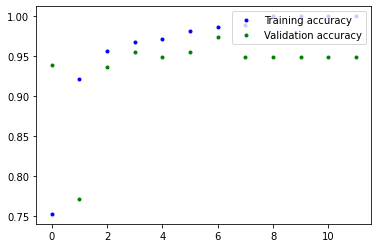

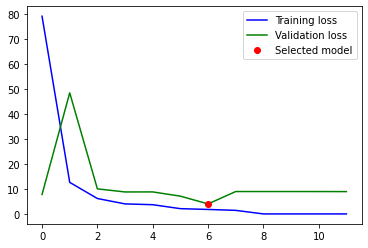

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
best_loss_epoch = np.argmin(val_loss)
best_loss = np.min(val_loss)
best_acc = val_acc[best_loss_epoch]

epochs = range(len(acc))

plt.plot(epochs, acc, 'b.', label='Training accuracy')
plt.plot(epochs, val_acc, 'g.', label='Validation accuracy')
plt.legend(loc='upper right')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.plot(best_loss_epoch, best_loss, 'ro', label='Selected model')
plt.legend(loc='upper right')

plt.show()


In [ ]:
with open(os.path.join(DIR_NAME, 'CNN_VGG16_standard/history'), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

# **DROPOUT**

It is good pratice to exploit different solution to assess if it is possible to maximise the results of the networks.
First technique applied is DROPOUT on a more complex network.

In [ ]:
inputs = keras.Input(shape=(300, 200, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
save_path = DIR_NAME + '/CNN_VGG16_Dropout/model.h5'

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True)
]

**Train the model**

In [ ]:
history = model.fit(
    training_images,
    epochs=30, 
    validation_data = val_images,
    callbacks = callbacks_list
)



Epoch 1/30
12/84 [===>..........................] - ETA: 15s - loss: 1.2138 - accuracy: 0.9948

KeyboardInterrupt: ignored

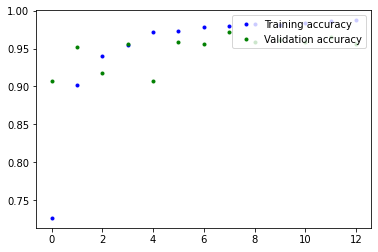

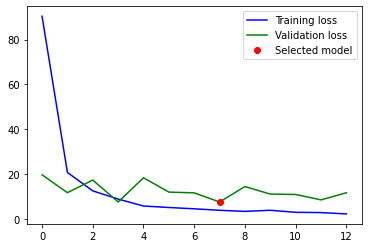

Lowest validation loss has been reached at epoch 7 with validation accuracy of 0.971


In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
best_loss_epoch = np.argmin(val_loss)
best_loss = np.min(val_loss)
best_acc = val_acc[best_loss_epoch]

epochs = range(len(acc))

plt.plot(epochs, acc, 'b.', label='Training accuracy')
plt.plot(epochs, val_acc, 'g.', label='Validation accuracy')
plt.legend(loc='upper right')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.plot(best_loss_epoch, best_loss, 'ro', label='Selected model')
plt.legend(loc='upper right')

plt.show()
print(f"Lowest validation loss has been reached at epoch {best_loss_epoch:d} with validation accuracy of {best_acc:.3f}")


In [ ]:
with open(os.path.join(DIR_NAME, 'CNN_VGG16_Dropout/history'), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

# **FINE TUNING** (first version)

Since the highest layers of the network have most likely learned to recognize features that are more specific
to the original dataset, we though that performing fine-tuning might be beneficial to the performance of the model. In particular we unlock the fifth layers of VGG16 network.

In [ ]:
model = models.load_model('/content/model/CNN_pretrained/CNN_VGG16_standard/model.h5')

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 50, 128)       0     


**Unlock the fifth layers of VGG16 network.** 

In [ ]:
for layer in model.get_layer('vgg16').layers:
  print(layer.name)
  print(layer.trainable)

print('\n-------------\n')

model.get_layer('vgg16').trainable = True

set_trainable = False
for layer in model.get_layer('vgg16').layers:

    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in conv_base.layers:
  print(layer.name)
  print(layer.trainable)

input_3
True
block1_conv1
False
block1_conv2
False
block1_pool
False
block2_conv1
False
block2_conv2
False
block2_pool
False
block3_conv1
False
block3_conv2
False
block3_conv3
False
block3_pool
False
block4_conv1
False
block4_conv2
False
block4_conv3
False
block4_pool
False
block5_conv1
False
block5_conv2
False
block5_conv3
False
block5_pool
False

-------------

input_3
False
block1_conv1
False
block1_conv2
False
block1_pool
False
block2_conv1
False
block2_conv2
False
block2_pool
False
block3_conv1
False
block3_conv2
False
block3_conv3
False
block3_pool
False
block4_conv1
False
block4_conv2
False
block4_conv3
False
block4_pool
False
block5_conv1
False
block5_conv2
False
block5_conv3
False
block5_pool
False


In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 300, 200, 3)]     0         
                                                                 
 tf.__operators__.getitem_3   (None, 300, 200, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 300, 200, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 9, 6, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 27648)             0         
                                                                 
 dense_8 (Dense)             (None, 128)               3539

In [ ]:
save_path = DIR_NAME +'/CNN_VGG16_Dropout_fineTuning/model.h5'

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=save_path,
        monitor="val_loss",
        verbose=1,
        save_best_only=True),
        stop_early
]

**Train the model after unfreezing the fith layer of the conv-base**

In [ ]:

history = model.fit(
    training_images,
    epochs=30, 
    validation_data = val_images,
    callbacks=callbacks_list)


Epoch 1/30
84/84 [==============================] - ETA: 0s - loss: 0.1801 - accuracy: 0.9963
Epoch 1: val_loss improved from inf to 5.76481, saving model to /content/model/CNN_pretrained/CNN_VGG16_Dropout_fineTuning/model.h5
84/84 [==============================] - 23s 249ms/step - loss: 0.1801 - accuracy: 0.9963 - val_loss: 5.7648 - val_accuracy: 0.9586
Epoch 2/30
84/84 [==============================] - ETA: 0s - loss: 0.0810 - accuracy: 0.9970
Epoch 2: val_loss did not improve from 5.76481
84/84 [==============================] - 21s 247ms/step - loss: 0.0810 - accuracy: 0.9970 - val_loss: 5.9291 - val_accuracy: 0.9554
Epoch 3/30
84/84 [==============================] - ETA: 0s - loss: 7.6392e-05 - accuracy: 1.0000
Epoch 3: val_loss improved from 5.76481 to 3.99550, saving model to /content/model/CNN_pretrained/CNN_VGG16_Dropout_fineTuning/model.h5
84/84 [==============================] - 21s 251ms/step - loss: 7.6392e-05 - accuracy: 1.0000 - val_loss: 3.9955 - val_accuracy: 0.9650

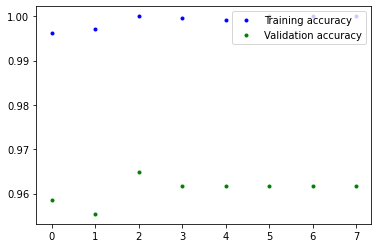

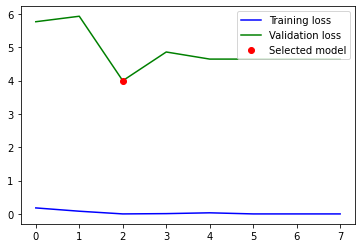

Lowest validation loss has been reached at epoch 2 with validation accuracy of 0.965


In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
best_loss_epoch = np.argmin(val_loss)
best_loss = np.min(val_loss)
best_acc = val_acc[best_loss_epoch]

epochs = range(len(acc))

plt.plot(epochs, acc, 'b.', label='Training accuracy')
plt.plot(epochs, val_acc, 'g.', label='Validation accuracy')
plt.legend(loc='upper right')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.plot(best_loss_epoch, best_loss, 'ro', label='Selected model')
plt.legend(loc='upper right')

plt.show()
print(f"Lowest validation loss has been reached at epoch {best_loss_epoch:d} with validation accuracy of {best_acc:.3f}")


In [ ]:
with open(os.path.join(DIR_NAME, 'CNN_VGG16_Dropout_fineTuning/history'), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

# Unlock from the fourth layer to the fifth layer of VGG16 network.
Trying to achieve even better results, we unfrozen from the fourth layer of the conv-base

In [ ]:
model2 = models.load_model('/content/model/CNN_pretrained/CNN_VGG16_standard/model.h5')

In [ ]:
for layer in model2.get_layer('vgg16').layers:
  print(layer.name)
  print(layer.trainable)

print('\n-------------\n')

model2.get_layer('vgg16').trainable = True

set_trainable = False
for layer in model2.get_layer('vgg16').layers:

    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in conv_base.layers:
  print(layer.name)
  print(layer.trainable)

input_3
True
block1_conv1
False
block1_conv2
False
block1_pool
False
block2_conv1
False
block2_conv2
False
block2_pool
False
block3_conv1
False
block3_conv2
False
block3_conv3
False
block3_pool
False
block4_conv1
False
block4_conv2
False
block4_conv3
False
block4_pool
False
block5_conv1
False
block5_conv2
False
block5_conv3
False
block5_pool
False

-------------

input_3
False
block1_conv1
False
block1_conv2
False
block1_pool
False
block2_conv1
False
block2_conv2
False
block2_pool
False
block3_conv1
False
block3_conv2
False
block3_conv3
False
block3_pool
False
block4_conv1
False
block4_conv2
False
block4_conv3
False
block4_pool
False
block5_conv1
False
block5_conv2
False
block5_conv3
False
block5_pool
False


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 50, 128)       0     

In [ ]:
model2.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

In [ ]:
model2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 300, 200, 3)]     0         
                                                                 
 tf.__operators__.getitem_3   (None, 300, 200, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 300, 200, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 9, 6, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 27648)             0         
                                                                 
 dense_8 (Dense)             (None, 128)               3539

In [ ]:
save_path = DIR_NAME + '/CNN_VGG16_Dropout_fineTuning2/model.h5'

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=save_path,
        monitor="val_loss",
        verbose=1,
        save_best_only=True),
        stop_early
]

**Train the model after unfreezing the top two layers of the conv base**

In [ ]:

history = model2.fit(
    training_images,
    epochs=30,
    validation_data = val_images,
    callbacks=callbacks_list)


Epoch 1/30
84/84 [==============================] - ETA: 0s - loss: 0.5270 - accuracy: 0.9925
Epoch 1: val_loss improved from inf to 8.66834, saving model to /content/model/CNN_pretrained/CNN_VGG16_Dropout_fineTuning2/model.h5
84/84 [==============================] - 29s 321ms/step - loss: 0.5270 - accuracy: 0.9925 - val_loss: 8.6683 - val_accuracy: 0.9363
Epoch 2/30
84/84 [==============================] - ETA: 0s - loss: 0.2520 - accuracy: 0.9929
Epoch 2: val_loss improved from 8.66834 to 3.66639, saving model to /content/model/CNN_pretrained/CNN_VGG16_Dropout_fineTuning2/model.h5
84/84 [==============================] - 26s 312ms/step - loss: 0.2520 - accuracy: 0.9929 - val_loss: 3.6664 - val_accuracy: 0.9618
Epoch 3/30
84/84 [==============================] - ETA: 0s - loss: 3.9169e-05 - accuracy: 1.0000
Epoch 3: val_loss improved from 3.66639 to 2.45946, saving model to /content/model/CNN_pretrained/CNN_VGG16_Dropout_fineTuning2/model.h5
84/84 [==============================] - 27

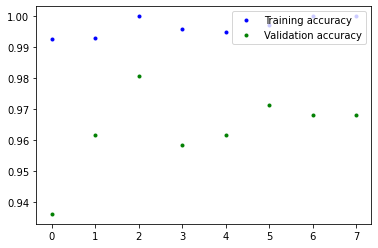

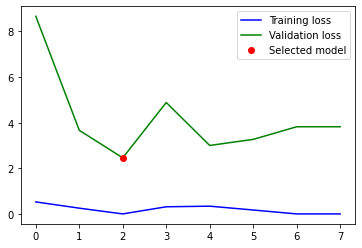

Lowest validation loss has been reached at epoch 2 with validation accuracy of 0.981


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
best_loss_epoch = np.argmin(val_loss)
best_loss = np.min(val_loss)
best_acc = val_acc[best_loss_epoch]

epochs = range(len(acc))

plt.plot(epochs, acc, 'b.', label='Training accuracy')
plt.plot(epochs, val_acc, 'g.', label='Validation accuracy')
plt.legend(loc='upper right')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.plot(best_loss_epoch, best_loss, 'ro', label='Selected model')
plt.legend(loc='upper right')

plt.show()
print(f"Lowest validation loss has been reached at epoch {best_loss_epoch:d} with validation accuracy of {best_acc:.3f}")


In [ ]:
with open(os.path.join(DIR_NAME, 'CNN_VGG16_Dropout_fineTuning2/history'), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [ ]:
!zip -r "Shareddrives/industrial/modelli/VGG16Test2.zip" "/content/model"

  adding: content/model/ (stored 0%)
  adding: content/model/CNN_pretrained/ (stored 0%)
  adding: content/model/CNN_pretrained/CNN_VGG16_standard/ (stored 0%)
  adding: content/model/CNN_pretrained/CNN_VGG16_standard/.ipynb_checkpoints/ (stored 0%)
  adding: content/model/CNN_pretrained/CNN_VGG16_standard/model.h5 (deflated 7%)
  adding: content/model/CNN_pretrained/CNN_VGG16_standard/history (deflated 50%)
  adding: content/model/CNN_pretrained/.ipynb_checkpoints/ (stored 0%)
  adding: content/model/CNN_pretrained/CNN_VGG16_Dropout_fineTuning/ (stored 0%)
  adding: content/model/CNN_pretrained/CNN_VGG16_Dropout_fineTuning/model.h5 (deflated 9%)
  adding: content/model/CNN_pretrained/CNN_VGG16_Dropout_fineTuning/history (deflated 50%)
  adding: content/model/CNN_pretrained/CNN_VGG16_Dropout_fineTuning2/ (stored 0%)
  adding: content/model/CNN_pretrained/CNN_VGG16_Dropout_fineTuning2/model.h5 (deflated 8%)
  adding: content/model/CNN_pretrained/CNN_VGG16_Dropout_fineTuning2/history (de